# ***Detecting presence of Heart Disease using classification***
#### Group Members: Ishan Kumar Singh, Tony Kashimori, Jeffrey Kim

### Introduction

Heart diseases, a global health concern, predominantly affect the elderly. With countless victims each year, early detection remains crucial. 

Our project investigates the likelihood of heart disease using key indicators: age, sex, resting blood pressure, cholesterol, and maximum heart rate.

The primary question is: **"Can age, sex, resting blood pressure, cholesterol, and maximum heart rate predict heart disease?"** 

The data set combines five heart datasets, offering the most extensive collection on heart disease prediction with 918 unique observations, focusing on key indicators to assess heart disease risk. Shedding light on these factors' roles, enhances our understanding of future preventive medical approaches.

## Methods

### Preliminary exploratory data analysis

In [24]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(dplyr)

In [25]:
data <- read_csv("https://raw.githubusercontent.com/jeffreyykim/DSCI-project-009-40-Group_Contract/94fda1d002bf5ab24d2be98a7c63061a1dad7ab0/heart.csv")

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
# cleaning and wrangling the data, renaming the values in a column
set.seed(1)
data <- data |>
        mutate(HeartDisease = as_factor(HeartDisease)) |>
        mutate(HeartDisease = fct_recode(HeartDisease, "Positive" = "1", "Negative" = "0"))
# selecting only the relevant columns
selected_data <- select(data, HeartDisease, Cholesterol,  Age, RestingBP, MaxHR, Sex) |>
                 filter(Cholesterol != 0, MaxHR !=0, RestingBP != 0) |>
                mutate(Male=as.integer(Sex == "M")) |>
                select(-Sex)
                 # mutate(Sex = as.factor(Sex)) |> mutate(Sex = fct_recode(Sex, "1" = "M", "0" = "F"))
selected_data

# spliting data into testing and training sets
data_split <- initial_split(selected_data, prop = 0.75, strata = HeartDisease)
training_data <- training(data_split)
testing_data <- testing(data_split)
training_data
testing_data

HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,289,40,140,172,1
Positive,180,49,160,156,0
Negative,283,37,130,98,1
⋮,⋮,⋮,⋮,⋮,⋮
Positive,131,57,130,115,1
Positive,236,57,130,174,0
Negative,175,38,138,173,1


HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,289,40,140,172,1
Negative,283,37,130,98,1
Negative,204,39,120,145,1
⋮,⋮,⋮,⋮,⋮,⋮
Positive,193,68,144,141,1
Positive,131,57,130,115,1
Positive,236,57,130,174,0


HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,195,54,150,122,1
Negative,339,39,120,170,1
Negative,237,45,130,170,0
⋮,⋮,⋮,⋮,⋮,⋮
Negative,253,47,130,179,1
Positive,203,61,148,161,1
Negative,175,38,138,173,1


In [27]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [28]:
set.seed(1)
knn_recipe <- recipe(HeartDisease ~ . , data = training_data) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors()) 
knn_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Centering for all_predictors()
Scaling for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [29]:
# characteristics of the training data
training_data |>
group_by(HeartDisease, Male) |>
summarize(Mean_Cholesterol = mean(Cholesterol, na.rm = TRUE), Mean_Age = mean(Age, na.rm = TRUE), Mean_RestingBP = mean(RestingBP, na.rn = TRUE),
          Mean_MaxHR = mean(MaxHR, na.rm = TRUE))

`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease,Male,Mean_Cholesterol,Mean_Age,Mean_RestingBP,Mean_MaxHR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,0,252.3048,51.26667,130.0095,148.3810
Negative,1,233.0695,49.68984,131.0053,149.5561
Positive,0,275.1765,55.82353,143.0294,141.5882
Positive,1,245.6438,55.88412,135.9485,129.9957


In [30]:
set.seed(1)

grid_vals <- tibble(neighbors = 1:200)

knn_vfold <- vfold_cv(training_data, v = 5, strata = HeartDisease)


knn_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = knn_vfold, grid = grid_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy")
knn_fit


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6440883,5,0.01340722,Preprocessor1_Model001
2,accuracy,binary,0.6440883,5,0.01340722,Preprocessor1_Model002
3,accuracy,binary,0.6655824,5,0.01061307,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
198,accuracy,binary,0.7011082,5,0.01633995,Preprocessor1_Model198
199,accuracy,binary,0.6975365,5,0.01723438,Preprocessor1_Model199
200,accuracy,binary,0.6975365,5,0.01723438,Preprocessor1_Model200


Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_line()`).”


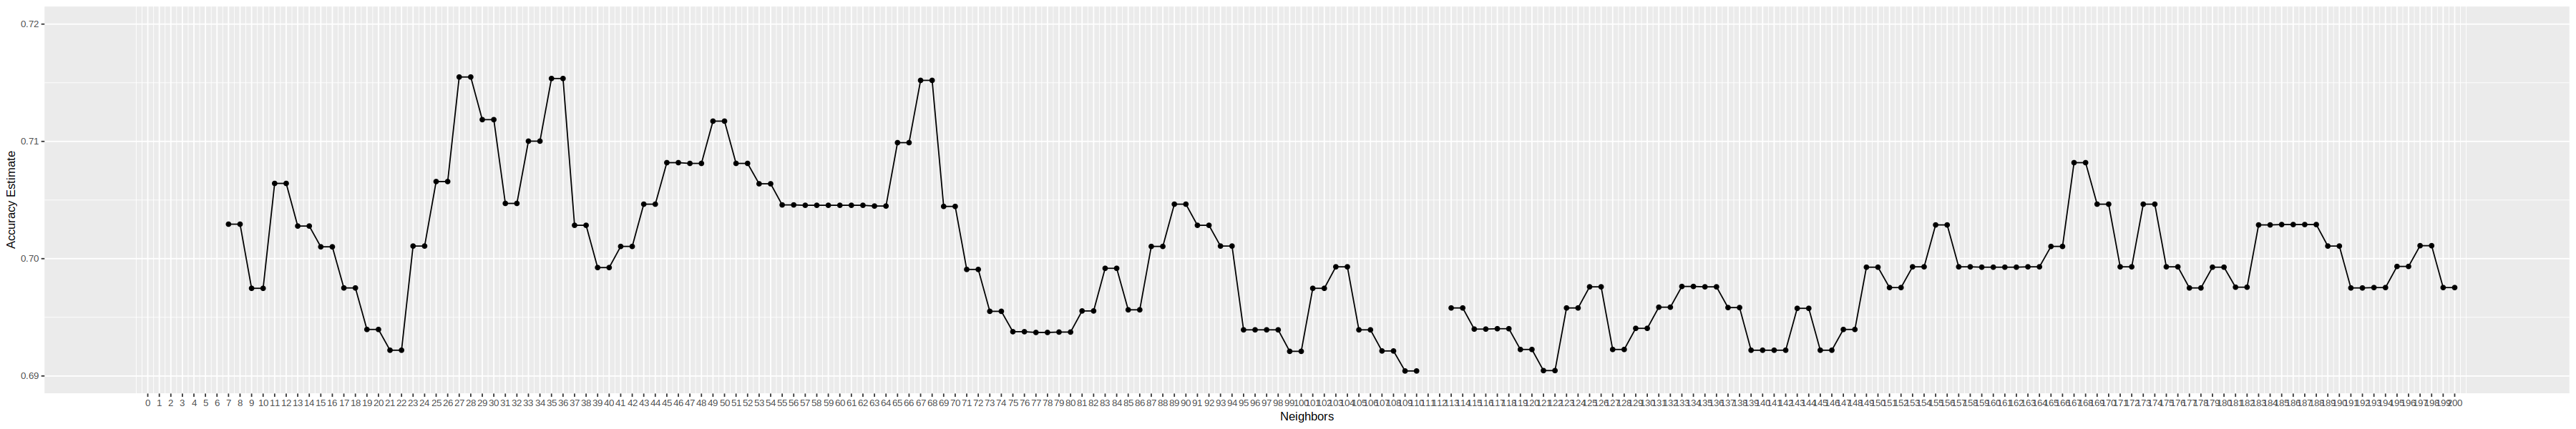

In [45]:
options(repr.plot.width = 30, repr.plot.height = 5)
accuracy_versus_k <- ggplot(knn_fit, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 10)) +
      scale_x_continuous(breaks = seq(0, 200, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.69, 0.72)) # adjusting the y-axis 
accuracy_versus_k

In [51]:
max_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
            set_engine("kknn") |>
            set_mode("classification")
max_k_spec
max_k_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(max_k_spec) |>
            fit(data = training_data)

test_predictions <- predict(max_k_fit , testing_data) |>
      bind_cols(testing_data)
test_predictions

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 27
  weight_func = rectangular

Computational engine: kknn 


.pred_class,HeartDisease,Cholesterol,Age,RestingBP,MaxHR,Male
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Positive,Negative,195,54,150,122,1
Negative,Negative,339,39,120,170,1
Negative,Negative,237,45,130,170,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Negative,Negative,253,47,130,179,1
Negative,Positive,203,61,148,161,1
Negative,Negative,175,38,138,173,1


In [52]:
test_prediction_accuracy <- test_predictions |>
        metrics(truth = HeartDisease, estimate = .pred_class)    
test_prediction_accuracy
confusion_mat <- test_predictions |> 
      conf_mat(truth = HeartDisease, estimate = .pred_class)
confusion_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7593583
kap,binary,0.5178479


          Truth
Prediction Negative Positive
  Negative       75       22
  Positive       23       67

In [53]:
precision <- 67 / (67 + 23)
precision
recall <- 67 / (67 + 22)
recall

[1] 0.7444444

[1] 0.752809